In [3]:
import numpy as np
from bson import json_util
import helix as hx
from helix import units
import numpy as np
import strax as sx                    
from matplotlib import pyplot as plt
from glob import glob 
import os
import shutil
from scipy.signal import savgol_filter, medfilt

raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
run = 'run10' 
duration = 10  # seconds
baseline_step = 0  # add a baseline equal to baseline_step*channel_index to each channel 

In [4]:
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])  
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 0}  # for the hx.NoiseEvents plugin

context.set_config(config)
events = context.get_array(run, 'events')

raw_data = events['channel_data']
raw_data.shape

Loading events: |                   | 0.00 % [00:00<?], #1 (0.03 s). 4012.0 MB/s


(9, 50, 33168)

In [5]:
indices_to_remove = np.array([4, 2])
channel0_data_excl = np.delete(raw_data[:, 0, :], indices_to_remove, axis=0)

# Apply Savitzky-Golay filter to smooth traces (vectorized operation)
processed_traces = savgol_filter(channel0_data_excl, window_length=51, polyorder=3, axis=1)

# Compute Mean Template & Apply Median Filtering
filtered_template = medfilt(np.mean(processed_traces, axis=0), kernel_size=81)

# Normalize to [0, 1] (vectorized)
normalized_template = (filtered_template - filtered_template.min()) / (filtered_template.ptp())

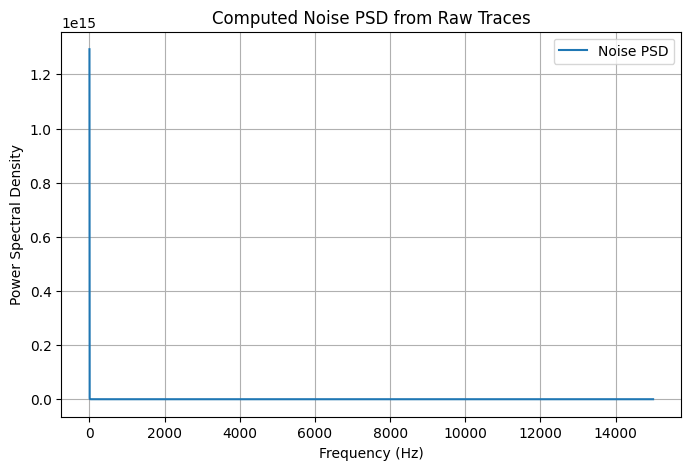

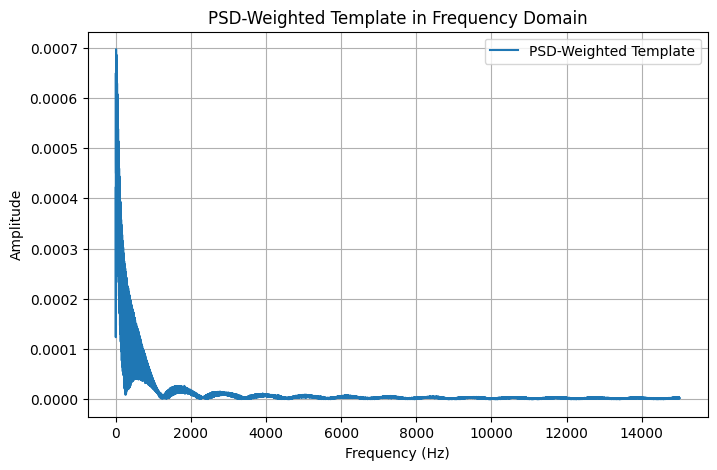

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d

def compute_psd_from_traces(traces, sampling_frequency):
    """
    Compute the average Power Spectral Density (PSD) from raw traces,
    using only the latter half of each trace to avoid artifacts from the
    steeply rising edge. The PSD is then interpolated to recover finer binning.
    
    Parameters:
    - traces: 2D numpy array of shape (n_traces, trace_length)
    - sampling_frequency: Sampling rate in Hz
    
    Returns:
    - interpolated_psd: 1D array representing the interpolated noise PSD
    - interpolated_frequencies: Corresponding frequency axis
    """
    trace_length = traces.shape[1]
    selected_start = int(0.6 * trace_length)  # Start at 30% of trace
    selected_end = int(0.9 * trace_length)  # End at 80% of trace
    selected_trace_length = selected_end - selected_start
    psd_accum = np.zeros(selected_trace_length)

    # Compute FFT for each trace using only the selected portion
    for trace in traces:
        trace_fft = fft(trace[selected_start:selected_end])  # FFT of 30%-80% range
        psd_accum += np.abs(trace_fft) ** 2  # Power Spectrum

    # Average PSD over all traces
    psd = psd_accum / len(traces)
    
    # Compute frequency axis for reduced resolution
    frequencies = fftfreq(selected_trace_length, d=1/sampling_frequency)
    
    # Interpolate to match the full trace resolution
    interp_func = interp1d(frequencies[:selected_trace_length // 2], psd[:selected_trace_length // 2], kind='linear', fill_value='extrapolate')
    full_frequencies = fftfreq(trace_length, d=1/sampling_frequency)
    interpolated_psd = interp_func(full_frequencies[:trace_length // 2])

    return interpolated_psd, full_frequencies[:trace_length // 2]

def compute_psd_template(fitting_template, psd, sampling_frequency):
    """
    Compute a PSD-weighted template from a time-domain fitting template.
    
    Parameters:
    - fitting_template: 1D numpy array (signal template in time domain)
    - psd: 1D numpy array (precomputed noise PSD, half length)
    - sampling_frequency: Sampling rate in Hz
    
    Returns:
    - template_psd: Frequency domain representation of the template
    - frequencies: Corresponding frequency axis
    """
    trace_length = len(fitting_template)
    
    # FFT of the fitting template (full length)
    template_fft = fft(fitting_template)
    
    # Extend PSD to full length (mirror the second half for real-valued signals)
    full_psd = np.concatenate([psd, psd[::-1]])  # Mirror PSD
    
    # Normalize by the PSD (avoid division by zero)
    psd_normalized = np.where(full_psd > 0, full_psd, 1)  # Avoid division by zero
    template_psd = template_fft / np.sqrt(psd_normalized)

    # Compute frequency axis
    frequencies = fftfreq(trace_length, d=1/sampling_frequency)

    return template_psd[:trace_length // 2], frequencies[:trace_length // 2]


# Example Usage:
sampling_frequency = 30000#hx.DEFAULT_SAMPLING_FREQUENCY
trace_length = 32768  # Length of traces

# Compute noise PSD from raw traces
noise_psd, freq_axis = compute_psd_from_traces(processed_traces, sampling_frequency)

# Compute PSD-weighted template
template_psd, template_freq_axis = compute_psd_template(normalized_template, noise_psd, sampling_frequency)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(freq_axis, noise_psd, label="Noise PSD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Computed Noise PSD from Raw Traces")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(template_freq_axis, np.abs(template_psd), label="PSD-Weighted Template")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("PSD-Weighted Template in Frequency Domain")
plt.legend()
plt.grid(True)
plt.show()


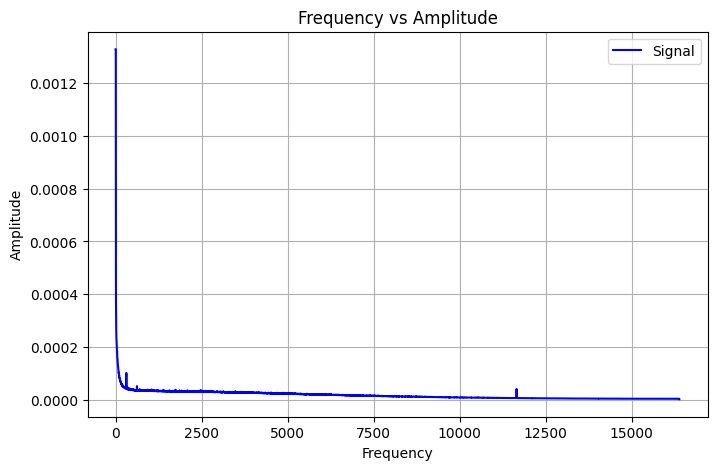

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
file_path = "plugins/event_rqs/noise_psd_from_MMC.npy"  # Change this to your actual file path
data = np.load(file_path)

# Ensure the data has two columns: frequency and amplitude
if data.ndim == 1:
    frequency = np.arange(len(data))  # Generate indices as frequency if not provided
    amplitude = data
elif data.shape[1] == 2:
    frequency, amplitude = data[:, 0], data[:, 1]
else:
    raise ValueError("Unexpected .npy file format. Expected 1D or 2D with two columns.")

# Plot the data
plt.figure(figsize=(8, 5))
plt.plot(frequency, amplitude, label="Signal", color='b')

# Labels and title
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Frequency vs Amplitude")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


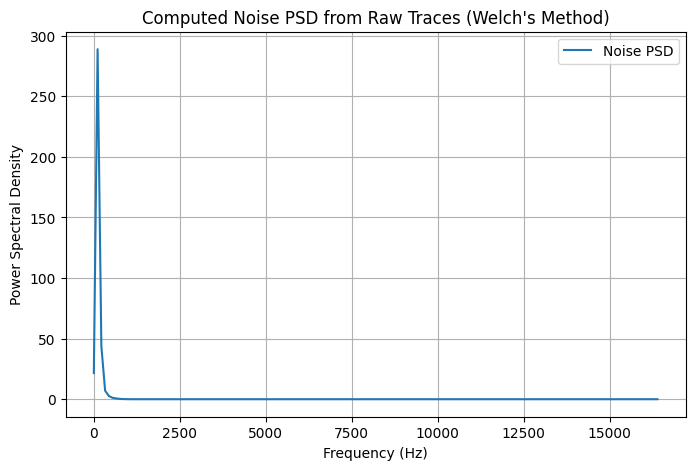

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import welch, get_window

def compute_psd_from_traces(traces, sampling_frequency, segment_length=300, window_type='hann'):
    """
    Compute the Power Spectral Density (PSD) using Welch's method
    for better spectral resolution and reduced variance.
    
    Parameters:
    - traces: 2D numpy array of shape (n_traces, trace_length)
    - sampling_frequency: Sampling rate in Hz
    - segment_length: Length of each segment for Welch's method (default: trace_length // 4)
    - window_type: Windowing function for spectral analysis
    
    Returns:
    - psd: 1D array representing the averaged noise PSD
    - frequencies: Corresponding frequency axis
    """
    trace_length = traces.shape[1]
    if segment_length is None:
        segment_length = trace_length // 4  # Default to 1/4th of the trace length
    
    window = get_window(window_type, segment_length)
    
    # Compute PSD using Welch’s method
    psd_accum = np.zeros(segment_length // 2 + 1)
    
    for trace in traces:
        freqs, psd = welch(trace, fs=sampling_frequency, window=window, nperseg=segment_length, scaling='density')
        psd_accum += psd
    
    # Average PSD over all traces
    psd_avg = psd_accum / len(traces)
    
    return psd_avg, freqs

def compute_psd_template(fitting_template, psd, sampling_frequency):
    """
    Compute a PSD-weighted template from a time-domain fitting template.
    
    Parameters:
    - fitting_template: 1D numpy array (signal template in time domain)
    - psd: 1D numpy array (precomputed noise PSD)
    - sampling_frequency: Sampling rate in Hz
    
    Returns:
    - template_psd: Frequency domain representation of the template
    - frequencies: Corresponding frequency axis
    """
    trace_length = len(fitting_template)
    
    # FFT of the fitting template
    template_fft = fft(fitting_template)
    
    # Normalize by the PSD (avoid division by zero)
    psd_normalized = np.where(psd > 0, psd, 1)  # Avoid division by zero
    template_psd = template_fft[:len(psd)] / np.sqrt(psd_normalized)
    
    # Compute frequency axis
    frequencies = fftfreq(trace_length, d=1/sampling_frequency)[:len(psd)]
    
    return template_psd, frequencies

# Example Usage:
sampling_frequency = 32768
trace_length = 32768  # Length of traces

# Compute noise PSD from raw traces
noise_psd, freq_axis = compute_psd_from_traces(processed_traces, sampling_frequency)

# Compute PSD-weighted template
template_psd, template_freq_axis = compute_psd_template(normalized_template, noise_psd, sampling_frequency)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(freq_axis, noise_psd, label="Noise PSD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Computed Noise PSD from Raw Traces (Welch's Method)")
plt.legend()
plt.grid(True)
plt.show()


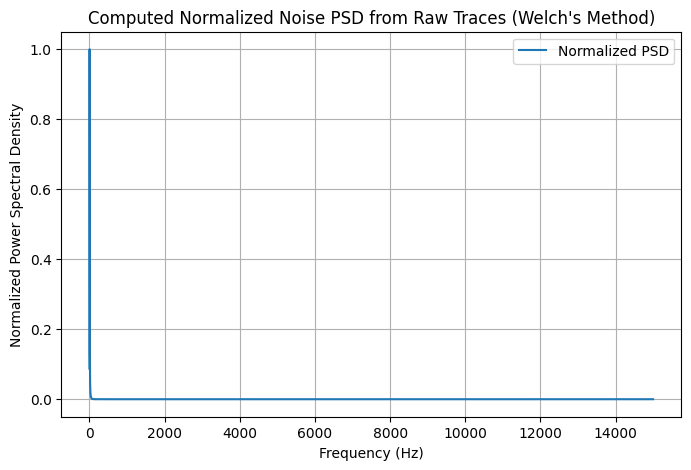

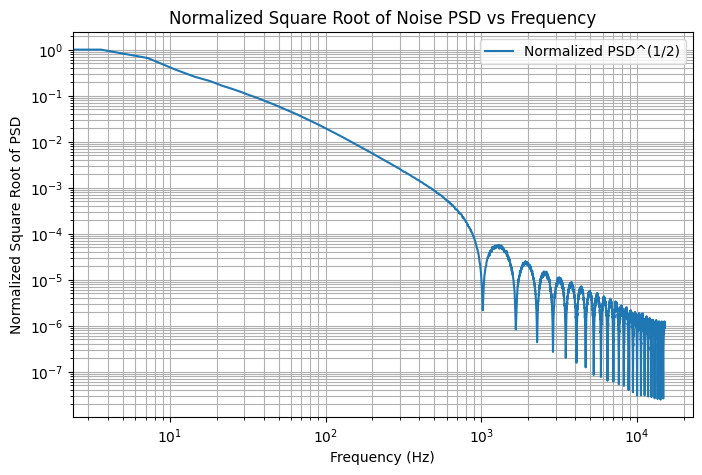

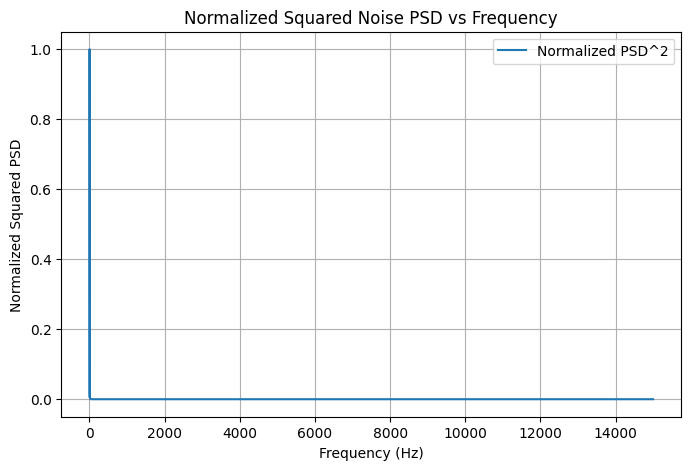

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, get_window

def compute_psd_from_traces(traces, sampling_frequency, segment_length=None, window_type='hann'):
    """
    Compute the Power Spectral Density (PSD) using Welch's method
    for better spectral resolution and reduced variance.
    
    Parameters:
    - traces: 2D numpy array of shape (n_traces, trace_length)
    - sampling_frequency: Sampling rate in Hz
    - segment_length: Length of each segment for Welch's method (default: trace_length // 4)
    - window_type: Windowing function for spectral analysis
    
    Returns:
    - psd: 1D array representing the averaged noise PSD
    - frequencies: Corresponding frequency axis
    """
    trace_length = traces.shape[1]
    if segment_length is None:
        segment_length = trace_length // 4  # Default to 1/4th of the trace length
    
    window = get_window(window_type, segment_length)
    
    # Compute PSD using Welch’s method
    psd_accum = np.zeros(segment_length // 2 + 1)
    
    for trace in traces:
        freqs, psd = welch(trace, fs=sampling_frequency, window=window, nperseg=segment_length, scaling='density')
        psd_accum += psd
    
    # Average PSD over all traces
    psd_avg = psd_accum / len(traces)
    
    # Normalize PSD
    psd_max = np.max(psd_avg)
    psd_avg /= psd_max  # Normalize to max value of 1
    
    return psd_avg, freqs

# Example Usage:
sampling_frequency = 30000
trace_length = 32768  # Length of traces

# Compute noise PSD from raw traces
noise_psd, freq_axis = compute_psd_from_traces(processed_traces, sampling_frequency)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(freq_axis, noise_psd, label="Normalized PSD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Power Spectral Density")
plt.title("Computed Normalized Noise PSD from Raw Traces (Welch's Method)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(freq_axis, np.sqrt(noise_psd), label="Normalized PSD^(1/2)")
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Square Root of PSD")
plt.title("Normalized Square Root of Noise PSD vs Frequency")
plt.legend()
plt.grid(True, which="both")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(freq_axis, noise_psd**2, label="Normalized PSD^2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Squared PSD")
plt.title("Normalized Squared Noise PSD vs Frequency")
plt.legend()
plt.grid(True)
plt.show()


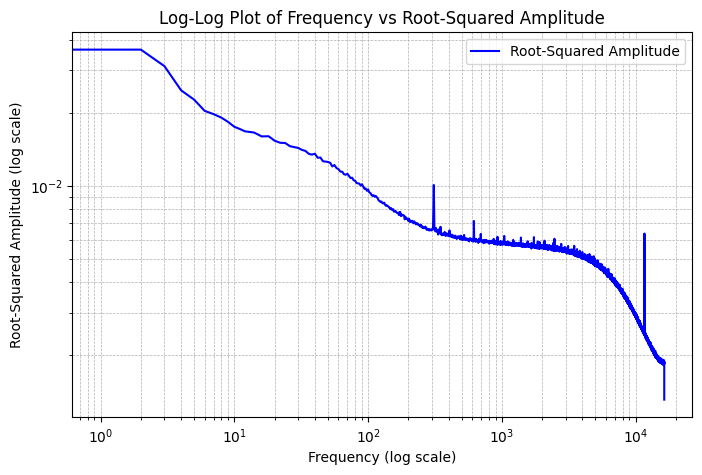

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file
file_path = "plugins/event_rqs/noise_psd_from_MMC.npy"  # Change this to your actual file path
data = np.load(file_path)

# Ensure the data has two columns: frequency and amplitude
if data.ndim == 1:
    frequency = np.arange(len(data))  # Generate indices as frequency if not provided
    amplitude = data
elif data.shape[1] == 2:
    frequency, amplitude = data[:, 0], data[:, 1]
else:
    raise ValueError("Unexpected .npy file format. Expected 1D or 2D with two columns.")

# Apply root-square transformation
amplitude_root_square = np.sqrt(np.abs(amplitude))

# Plot the data with logarithmic axes
plt.figure(figsize=(8, 5))
plt.loglog(frequency, amplitude_root_square, label="Root-Squared Amplitude", color='b')

# Labels and title
plt.xlabel("Frequency (log scale)")
plt.ylabel("Root-Squared Amplitude (log scale)")
plt.title("Log-Log Plot of Frequency vs Root-Squared Amplitude")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.show()


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def compute_and_plot_psds(traces, fs, nperseg=None):
    """
    Compute and plot the Power Spectral Density (PSD) for multiple raw traces.

    Parameters:
    - traces: list of 1D numpy arrays, each representing a raw trace.
    - fs: Sampling frequency in Hz.
    - nperseg: Number of samples per segment for Welch's method (default: auto).
    
    Returns:
    - freqs: Frequency values corresponding to the PSD.
    - psd_avg: Averaged PSD across all traces.
    """
    psds = []
    freqs = None

    plt.figure(figsize=(10, 6))
    
    for i, trace in enumerate(traces):
        # Compute PSD using Welch's method
        freqs, psd = welch(trace, fs=fs, nperseg=nperseg)
        psds.append(psd)
        
        # Plot individual PSDs (optional)
        plt.plot(freqs, psd, alpha=0.3, label=f'Trace {i+1}' if i < 5 else None)  # Limit legend entries

    # Compute average PSD
    psd_avg = np.mean(psds, axis=0)
    
    # Plot the average PSD
    #plt.plot(freqs, psd_avg, color='black', linewidth=2, label='Average PSD')
    
    # Formatting the plot
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (V²/Hz)')
    plt.title('Power Spectral Density (PSD) of Raw Traces')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.yscale('log')  # Log scale for better visualization
    
    plt.show()

    return freqs, psd_avg


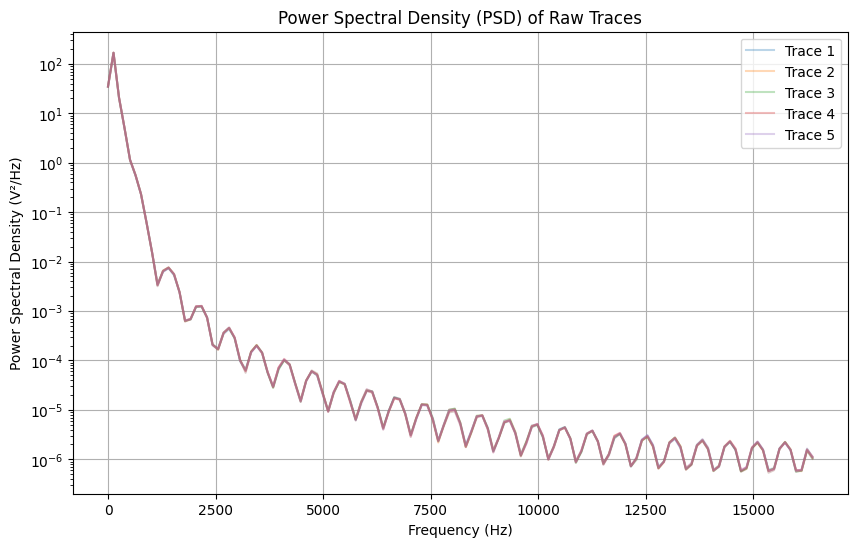

(array([    0.,   128.,   256.,   384.,   512.,   640.,   768.,   896.,
         1024.,  1152.,  1280.,  1408.,  1536.,  1664.,  1792.,  1920.,
         2048.,  2176.,  2304.,  2432.,  2560.,  2688.,  2816.,  2944.,
         3072.,  3200.,  3328.,  3456.,  3584.,  3712.,  3840.,  3968.,
         4096.,  4224.,  4352.,  4480.,  4608.,  4736.,  4864.,  4992.,
         5120.,  5248.,  5376.,  5504.,  5632.,  5760.,  5888.,  6016.,
         6144.,  6272.,  6400.,  6528.,  6656.,  6784.,  6912.,  7040.,
         7168.,  7296.,  7424.,  7552.,  7680.,  7808.,  7936.,  8064.,
         8192.,  8320.,  8448.,  8576.,  8704.,  8832.,  8960.,  9088.,
         9216.,  9344.,  9472.,  9600.,  9728.,  9856.,  9984., 10112.,
        10240., 10368., 10496., 10624., 10752., 10880., 11008., 11136.,
        11264., 11392., 11520., 11648., 11776., 11904., 12032., 12160.,
        12288., 12416., 12544., 12672., 12800., 12928., 13056., 13184.,
        13312., 13440., 13568., 13696., 13824., 13952., 14080., 

In [30]:
# Example usage:
fs = 1000  # Sampling frequency in Hz
compute_and_plot_psds(processed_traces, sampling_frequency)
